In [1]:
import warnings
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *

from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_manila')

In [2]:
backend_config = backend.configuration()

# Checking the Configuration

Now that we've loaded the real backend and grabbed the device configuration, we can check out the sampling time ```dt```. This is reported in seconds, but is nanoseconds in length.

In [3]:
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                        # 1e9 to get nanoseconds

Sampling time: 0.2222222222222222 ns


We can also check out the timing constraints, where everything is in multiples of ```dt```. `Granularity` determines pulse lengths.

The measurement pulse position must be an integer multiple of `acquire_alignment`, and the gate position must be an integer multiple of `pulse_alignment`.

In experiments with delays and gates, we must select a delay that is a common multiple of `acquire_alignment` and `pulse_alignment`.

In [4]:
backend.configuration().timing_constraints

{'acquire_alignment': 16,
 'granularity': 16,
 'min_length': 64,
 'pulse_alignment': 1}

In [5]:
acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']
import numpy as np

lcm = np.lcm(acquire_alignment, pulse_alignment)
print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")

Least common multiple of acquire_alignment and pulse_alignment: 16


There are some defaults that are accessible with estimates for qubit frequencies and programs to enact some operators.

This includes default frequencies for measurement and drive channels.

In [6]:
backend_defaults = backend.defaults()

q0_freq = backend_defaults.qubit_freq_est[0]  # Hz
q0_meas_freq = backend_defaults.meas_freq_est[0]  # Hz

GHz = 1e-9
print("DriveChannel(0) defaults to a modulation frequency of {} GHz.".format(q0_freq * GHz))
print("MeasureChannel(0) defaults to a modulation frequency of {} GHz.".format(q0_meas_freq * GHz))

DriveChannel(0) defaults to a modulation frequency of 4.962280054074476 GHz.
MeasureChannel(0) defaults to a modulation frequency of 7.163170819 GHz.


# Frequency Sweep to find Qubit Frequency

We can apply pulses of varying frequencies to check which ones are absorbed. This will give us a rough idea of the frequency that separates the $|0\rangle$ and $|1\rangle$ states. Here, we're sweeping over a windwo of 40 MHz with steps of 1 MHz.

In [7]:
# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 40 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 1 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")

Qubit 0 has an estimated frequency of 4.962280054074476 GHz.
The sweep will go from 4.942280054074477 GHz to 4.982280054074476 GHz in steps of 1.0 MHz.


We'll first need a few values: duration, sigma, channel.

The pulses are then executed sequentially in a pulse flow. We will define the pulse frequency for the drive pulse used in the experiment, and the measurement pulse. The drive pulse is usually Gaussian.



In [8]:
def get_closest_multiple_of(value, base_number):
    return int(value + base_number/2) - (int(value + base_number/2) % base_number)

We define a function that we use to determine the length of the pulse. Because `granularity` defines pulse length, we want the nearest multiple of a given number and `granularity` (which is 16 `dt` here). 

In [9]:
# Determining pulse length. Samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return get_closest_multiple_of(num, granularity)

Similarly, we need the length of delay. Recall from above that this has to be a common multiple of `acquire_alignment` and `pulse_alignment` (`lcm` variable).

In [10]:
# Adjusting length of delay. Convert seconds to dt
def get_dt_from(sec):
    return get_closest_multiple_of(sec/dt, lcm)

In [11]:
from qiskit import pulse                  # This is where we access all of our Pulse features!
from qiskit.circuit import Parameter      # This is Parameter Class for variable parameters.
from qiskit.circuit import QuantumCircuit, Gate

# Drive pulse parameters (us = microseconds)
drive_sigma_sec = 0.015 * us                           # This determines the actual width of the gaussian, sigma
drive_duration_sec = drive_sigma_sec * 8               # This is a truncating parameter, because gaussians don't have 
                                                       # a natural finite length
drive_amp = 0.05                                       # Arbitrarily set. Can go up to a maximum of 1 for any backend

freq = Parameter('freq') # Creates a string variable "freq". We could type φ=Parameter("freq") and every instance of 
                         # φ will return the string "freq"

# Creating a pulse schedule called "sweep_sched". It doesn't need to be referenced in this code block.
# Start with drive pulse acting on the drive channel
with pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as sweep_sched:
    # Finding out how long the Gaussian-modulated pulse needs to be. Converts the pulse duration into
    # samples, whose closest multiple of granularity (16) is then found.
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    
    # Again, converting the pulse width in seconds into samples
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    
    # Grabbing the drive channel for a specified qubit so that the pulse can be sent
    drive_chan = pulse.drive_channel(qubit)
    
    # Set the frequency of the drive channel - this is the frequency of the pulse
    pulse.set_frequency(freq, drive_chan)
    
    # Adding in the Gaussian pulse to the drive channel (actually adding it), with parameters in samples
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              sigma=drive_sigma,
                              amp=drive_amp,
                              name='freq_sweep_excitation_pulse'), drive_chan)

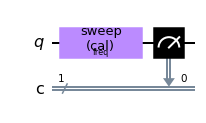

In [12]:
# We create a custom gate to apply to our circuit:
sweep_gate = Gate("sweep", 1, [freq])

qc_sweep = QuantumCircuit(1, 1)

qc_sweep.append(sweep_gate, [0])
qc_sweep.measure(0, 0)
# Adding the calibration here adds an extra gate
#     QuantumCircuit.add_calibration(gate, qubits, schedule, parameters)
# where gate can be a circuit.Gate object or a name
qc_sweep.add_calibration(sweep_gate, (0,), sweep_sched, [freq])
qc_sweep.draw()

In [13]:
# Create the frequency settings for the sweep (MUST BE IN HZ)
frequencies_Hz = frequencies_GHz*GHz

# This next line creates a list of circuits with different frequencies. The parameter "freq", wherever it appears in
# the circuit construction is given the value for f for every f in frequencies_HZ
# Parameters must be specified as a dictionary.
# https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.assign_parameters.html

# inplace = False creates a copy of the circuit. inplace=True modifies the existing circuit
exp_sweep_circs = [qc_sweep.assign_parameters({freq: f}, inplace=False) for f in frequencies_Hz]

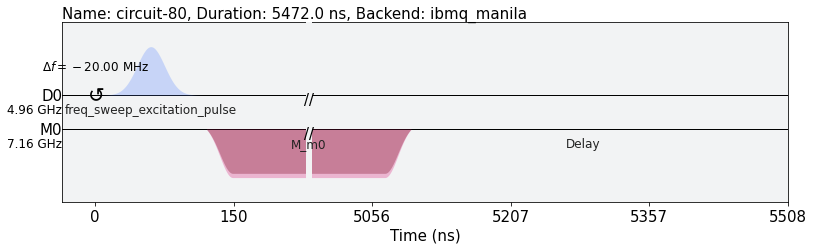

In [14]:
from qiskit import schedule
# Example of a sweep circuit for a given frequency
sweep_schedule = schedule(exp_sweep_circs[0], backend)
sweep_schedule.draw(backend=backend)

# The -20 MHz is the frequency adjustment from the expected frequency the backend provides.
# Since we're sweeping over 40MHz around this frequency, we go from -20 MHz to +20 MHz

Returning one complex value per shot `meas_level=1` and the average of each result, rather than each shot individually. Each point in the schedule (each point in the frequency sweep) is repeated `num_shots_per_frequency` times.

In [ ]:
num_shots_per_frequency = 2048

job = backend.run(exp_sweep_circs, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_frequency)
from qiskit.tools.monitor import job_monitor
job_monitor(job)

frequency_sweep_results = job.result(timeout=120) # timeout parameter set to 120 seconds

import matplotlib.pyplot as plt

sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])

np.savetxt("v=0.05, 2048 shots, 1 step gaussian frequencies.txt", frequencies_GHz, delimiter=",")
np.savetxt("v=0.05, 2048 shots, 1 step gaussian data.txt", np.real(sweep_values), delimiter=",")

Job Status: job is queued (83) 

Then, results

In [ ]:
frequency_sweep_results = job.result(timeout=120) # timeout parameter set to 120 seconds

import matplotlib.pyplot as plt

sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()


In [ ]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [ ]:
fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [1, 4.975, 1, -2] # initial parameters for curve_fit
                                )

In [ ]:
plt.scatter(frequencies_GHz, np.real(sweep_values), color='black')
plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [ ]:
A, rough_qubit_frequency, B, C = fit_params
rough_qubit_frequency = rough_qubit_frequency*GHz # make sure qubit freq is in Hz
print(f"We've updated our qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz to {round(rough_qubit_frequency/GHz, 5)} GHz.")

# $\Pi$ Pulses and the Rabi Experiment

Now we know the frequency between $|0\rangle$ and $|1\rangle$, we need to determine the amplitude to achieve this flip.

In [29]:
# This experiment uses these values from the previous experiment:
    # `qubit`,
    # `mem_slot`, and
    # `rough_qubit_frequency`.

# Rabi experiment parameters
num_rabi_points = 50

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [30]:
# Build the Rabi experiments:
#    A drive pulse at the qubit frequency, followed by a measurement,
#    where we vary the drive amplitude each time.

drive_amp = Parameter('drive_amp')
with pulse.build(backend=backend, default_alignment='sequential', name='Rabi Experiment') as rabi_sched:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='Rabi Pulse'), drive_chan)

In [31]:
rabi_gate = Gate("rabi", 1, [drive_amp])

qc_rabi = QuantumCircuit(1, 1)

qc_rabi.append(rabi_gate, [0])
qc_rabi.measure(0, 0)
qc_rabi.add_calibration(rabi_gate, (0,), rabi_sched, [drive_amp])

exp_rabi_circs = [qc_rabi.assign_parameters({drive_amp: a}, inplace=False) for a in drive_amps]

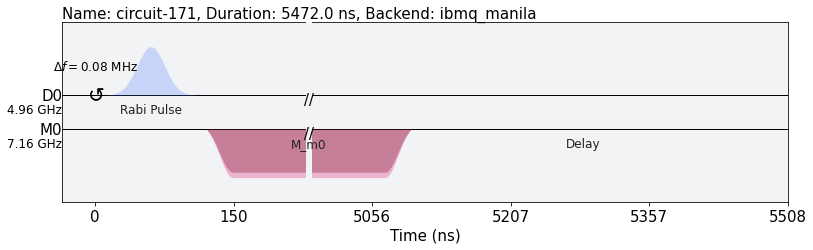

In [32]:
rabi_schedule = schedule(exp_rabi_circs[-1], backend)
rabi_schedule.draw(backend=backend)

In [33]:
num_shots_per_point = 1024

job = backend.run(exp_rabi_circs, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_point)

job_monitor(job)

Job Status: job has successfully run


In [ ]:
rabi_results = job.result(timeout=120)

# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)

In [ ]:
rabi_values = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(i)[qubit] * scale_factor)

rabi_values = np.real(baseline_remove(rabi_values))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values, color='black') # plot real part of Rabi values
plt.show()

In [ ]:
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [2, 0, 0.2, 0])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation

plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [ ]:
pi_amp = abs(drive_period / 2)
print(f"Pi Amplitude = {pi_amp}")